In [1]:
%pip install -q datasets transformers scikit-learn torch

# Task: Text Clustering with Custom KMeans

Using sentence_transformers, convert a set of texts into embeddings, and apply clustering using a custom implementation of KMeans. The goal is to group similar texts based on different distance metrics (such as cosine similarity, Euclidean distance, or Manhattan distance) implemented in the KMeans algorithm.

## 1. Data loading

Load the GO Emotions dataset from Hugging Face to obtain the texts that will be clustered. If you prefer some other dataset you can use it.

In [2]:
from datasets import load_dataset

dataset = load_dataset('google-research-datasets/go_emotions', split='train')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Print some examples

In [3]:
for i in range(5):
    print(f"Text {i+1}: {dataset[i]['text']}")

Text 1: My favourite food is anything I didn't have to cook myself.
Text 2: Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead
Text 3: WHY THE FUCK IS BAYLESS ISOING
Text 4: To make her feel threatened
Text 5: Dirty Southern Wankers


## 2. Convert texts to embeddings

Use the sentence-transformers library to transform the texts into embeddings (numerical vectors) for clustering.

In [4]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
import torch
import numpy as np
from tqdm.notebook import trange


def embed_bert_cls(text_list, model, tokenizer, batch_size=512):
    embeddings_list = []

    for i in trange(0, len(text_list), batch_size):
        batch_texts = text_list[i:i+batch_size]

        t = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt')

        with torch.no_grad():
            model_output = model(**{k: v.to(model.device) for k, v in t.items()})

        batch_embeddings = model_output.last_hidden_state[:, 0, :]
        batch_embeddings = torch.nn.functional.normalize(batch_embeddings)
        embeddings_list.append(batch_embeddings.cpu().numpy())

    return np.vstack(embeddings_list)


In [6]:
embeddings = embed_bert_cls(dataset[:]["text"], model, tokenizer)

  0%|          | 0/85 [00:00<?, ?it/s]

In [7]:
print(f"Shape of embeddings: {embeddings.shape}")

Shape of embeddings: (43410, 312)


## 3. Implement custom KMeans

Create a custom implementation of KMeans, supporting at least four different distance metrics (Correlation, Euclidean, Cosine, Mahalanobis). You shouldn't use any specific libs, only numpy.
Here are the formulas for correlation distance and Mahalanobis distance:

#### Correlation Distance
Correlation distance measures the difference in the direction of vectors rather than their magnitude. The formula for correlation distance is:

$$
d_{\text{corr}}(a, b) = 1 - \frac{\sum_{i=1}^{n}(a_i - \bar{a})(b_i - \bar{b})}{\sqrt{\sum_{i=1}^{n}(a_i - \bar{a})^2} \sqrt{\sum_{i=1}^{n}(b_i - \bar{b})^2}}
$$

where:
- $a$ and $b$ are two vectors,
- $\bar{a}$ and $\bar{b}$ are the mean values of the components of vectors $a$ and $b$, respectively.

or using ```np.corrcoef```:

$$
d_{\text{corr}}(a, b) = 1 - np.corrcoef(a, b)[0,1]
$$


#### Mahalanobis Distance
Mahalanobis distance accounts for not only the distance between points but also the covariance between them. The formula is:

$$
d_{\text{mahal}}(a, b) = \sqrt{(a - b)^T S^{-1} (a - b)}
$$

where:
- $a$ and $b$ are two vectors,
- $S$ is the covariance matrix of the features,
- $S^{-1}$ is the inverse covariance matrix.


In [26]:
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)


def cosine_distance(a, b):
    cosine_similarity = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return 1 - cosine_similarity


def mahalanobis_distance(a, b, inv_cov_matrix=None):
    delta = a - b
    if inv_cov_matrix is None:
        inv_cov_matrix = np.linalg.inv(np.cov(np.stack((a, b)).T))
    return np.sqrt(np.dot(np.dot(delta.T, inv_cov_matrix), delta))


def correlation_distance(a, b):
    correlation_coefficient = np.corrcoef(a, b)[0, 1]
    return 1 - correlation_coefficient

Implement custom K-Means class

In [27]:
class CustomKMeans:
    def __init__(self, n_clusters=3, max_iter=100, distance_metric='euclidean', **kwargs):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.distance_metric = distance_metric
        self.centroids = None
        self.labels_ = None
        self.kwargs = kwargs  # inverted covariation matrix for mahalanodis distance

    def fit(self, X):
        random_indices = np.random.choice(len(X), self.n_clusters, replace=False)
        self.centroids = X[random_indices]

        for _ in trange(self.max_iter):
            self.labels_ = np.array([self._assign_label(x) for x in X])

            new_centroids = np.array([X[self.labels_ == i].mean(axis=0) if len(X[self.labels_ == i]) > 0 else self.centroids[i] for i in range(self.n_clusters)])

            if np.allclose(self.centroids, new_centroids, atol=1e-6, rtol=1e-6):
                break
            self.centroids = new_centroids


    def _assign_label(self, x):
        # assigns each data point to the nearest centroid based on the chosen distance metric.
        # method returns the index of the closest centroid, which represents the cluster assignment (or label) for the given data point x
        distances = []
        for centroid in self.centroids:
            if self.distance_metric == 'euclidean':
                distance = euclidean_distance(x, centroid)
            elif self.distance_metric == 'cosine':
                distance = cosine_distance(x, centroid)
            elif self.distance_metric == 'mahalanobis':
                cov_matrix = self.kwargs.get('inv_cov_matrix')
                distance = mahalanobis_distance(x, centroid, inv_cov_matrix=inv_cov_matrix)
            elif self.distance_metric == 'correlation':
                distance = correlation_distance(x, centroid)
            else:
                raise ValueError(f"Unknown distance metric: {self.distance_metric}")

            distances.append(distance)
        return np.argmin(distances)


## 4. Fit the custom K-Means and visualize the results

Fit the custom KMeans model to the dataset using all of the distance metrics and obtain cluster labels.

In [10]:
n_clusters = 10

In [17]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_clusters(embeddings, labels, n_clusters=10):
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(n_clusters))
    plt.title("PCA-reduced 2D visualization of clusters")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

### Correlation distance

–£–º–µ–Ω—å—à–∏–ª –¥–∞—Ç–∞—Å–µ—Ç –≤ 10, —Ç.–∫. –≤—ã—á–∏—Å–ª–µ–Ω–∏—è –±—ã–ª–∏ –æ—á–µ–Ω—å –¥–æ–ª–≥–∏–º–∏...

In [35]:
custom_kmeans = CustomKMeans(n_clusters=n_clusters, distance_metric='correlation')
custom_kmeans.fit(embeddings[::10])

  0%|          | 0/100 [00:00<?, ?it/s]

In [36]:
labels = custom_kmeans.labels_

print("Custom KMeans labels for the first 10 texts:")
print(labels[:10])

Custom KMeans labels for the first 10 texts:
[6 6 6 3 5 4 4 4 7 8]


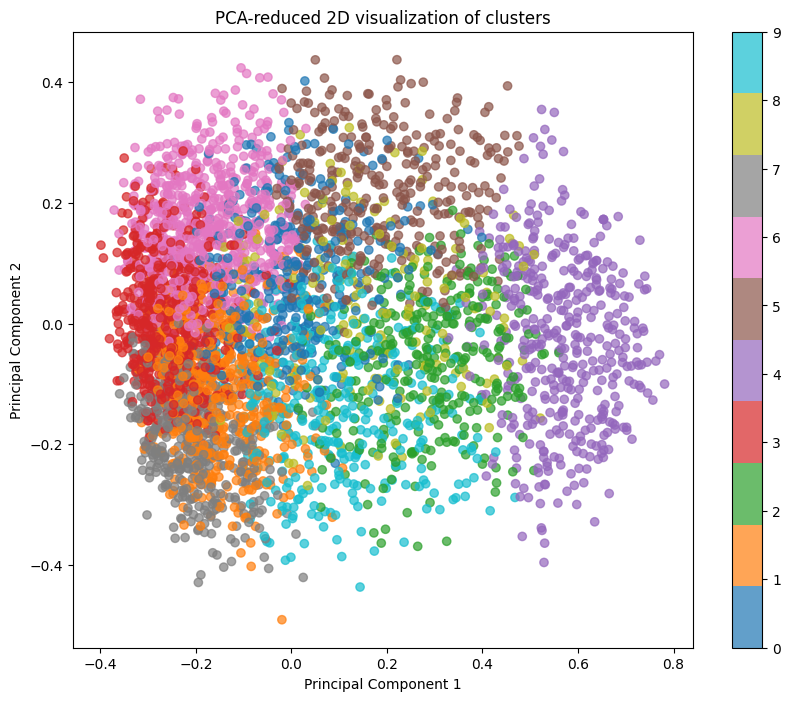

In [38]:
plot_clusters(embeddings[::10], labels, n_clusters=n_clusters)

In [40]:
for cluster in range(n_clusters):
    print(f"\nCluster {cluster}:")
    cluster_texts = [dataset[i]['text'] for i in range(len(dataset[::10]['text'])) if labels[i] == cluster]
    for text in cluster_texts[:5]:
        print(f"- {text}")


Cluster 0:
- Troll, bro. They know they're saying stupid shit. The motherfucker does nothing but stink up libertarian subs talking shit
- All sounds possible except the key, I can't see how it was missed in the first search. 
- 18 is hot but very bland, it's just here this blonde lady who is not as hot as blonde launch.
- Very interesting. Thx
- your mom likes to copy me cause she has no creativity just like you:

Cluster 1:
- [NAME] - same fucking problem, slightly better command of the English language.
- Fucking coward.
- i got a bump and a bald spot. i feel dumb <3
- Your aunt has some damn nerve, though!
- Ok, then what the actual fuck is your plan?

Cluster 2:
- Demographics? I don‚Äôt know anybody under 35 who has cable tv.
- I never thought it was at the same moment, but sometimes after [NAME] sacrifice... sounds logical
- You are going to do the dishes now
- Super, thanks
- I wouldn't let a sweet potato dictate decisions, ever.

Cluster 3:
- To make her feel threatened
- Aww.

### Cosine similarity

In [14]:
custom_kmeans = CustomKMeans(n_clusters=n_clusters, distance_metric='cosine')
custom_kmeans.fit(embeddings)

  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
labels = custom_kmeans.labels_

print("Custom KMeans labels for the first 10 texts:")
print(labels[:10])

Custom KMeans labels for the first 10 texts:
[4 0 7 1 7 2 9 0 5 0]


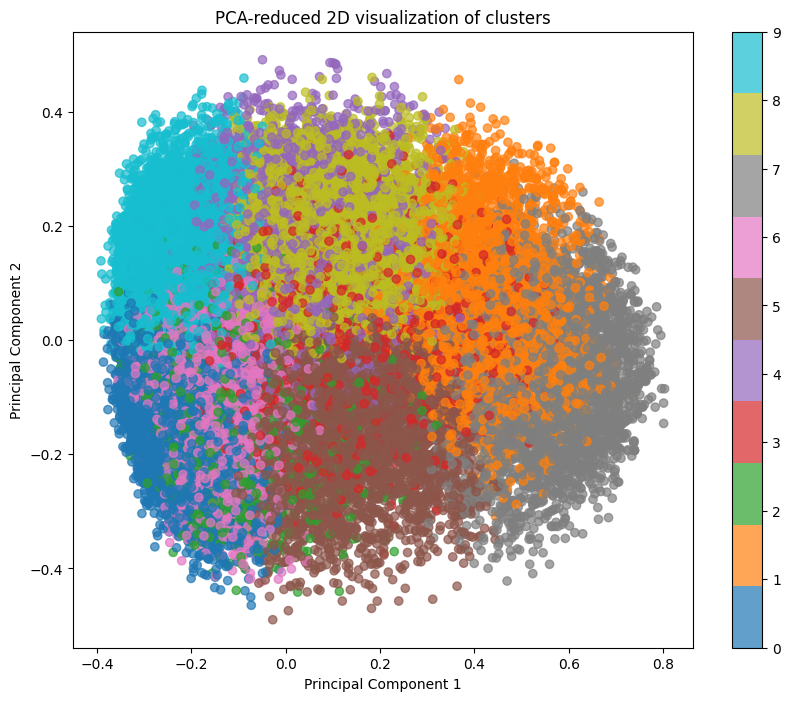

In [18]:
plot_clusters(embeddings, labels, n_clusters=n_clusters)

In [19]:
for cluster in range(n_clusters):
    print(f"\nCluster {cluster}:")
    cluster_texts = [dataset[i]['text'] for i in range(len(dataset[:]['text'])) if labels[i] == cluster]
    for text in cluster_texts[:5]:
        print(f"- {text}")


Cluster 0:
- Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead
- We need more boards and to create a bit more space for [NAME]. Then we‚Äôll be good.
- It might be linked to the trust factor of your friend.
- R/sleeptrain Might be time for some sleep training. Take a look and try to feel out what's right for your family.
- Oh forgive us for trying to make an exciting atmosphere at our homecourt.

Cluster 1:
- To make her feel threatened
- Slowing things down now
- Happy to be able to help.
- aw, thanks! I appreciate that! 
- You can always kneel.

Cluster 2:
- OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.
- A new study just came out from China that it's actually too late.
- I read on a different post that he died shortly after of internal injuries.
- He was off by 5 minutes, not impressed. 
- I think the 90 day rule applies to increases over 5%?

Cluster 3:
- that is wha

### Euclidean distance

In [20]:
custom_kmeans = CustomKMeans(n_clusters=n_clusters, distance_metric='euclidean')
custom_kmeans.fit(embeddings)

  0%|          | 0/100 [00:00<?, ?it/s]

In [21]:
labels = custom_kmeans.labels_

print("Custom KMeans labels for the first 10 texts:")
print(labels[:10])

Custom KMeans labels for the first 10 texts:
[2 0 8 8 5 3 9 3 3 7]


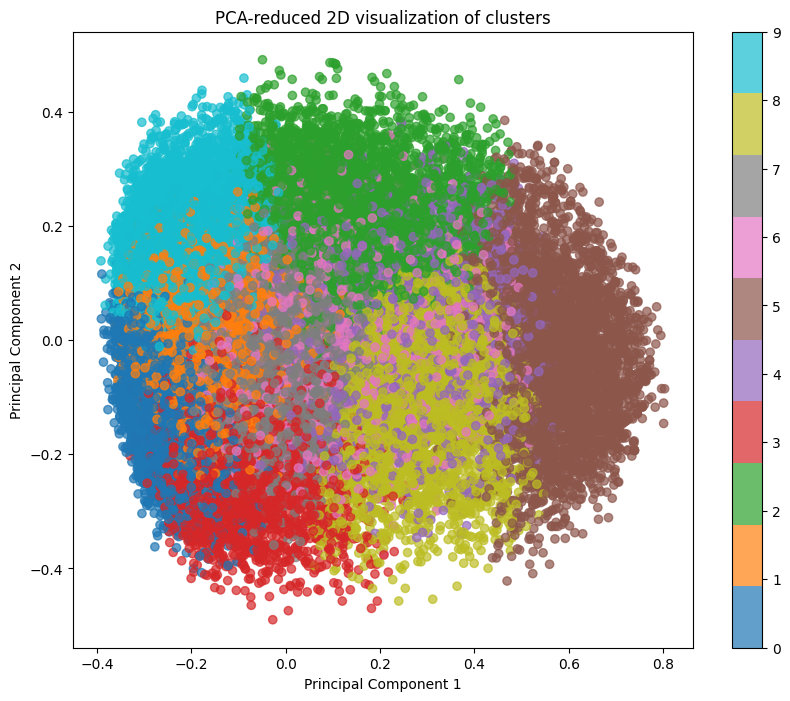

In [22]:
plot_clusters(embeddings, labels, n_clusters=n_clusters)

In [23]:
for cluster in range(n_clusters):
    print(f"\nCluster {cluster}:")
    cluster_texts = [dataset[i]['text'] for i in range(len(dataset[:]['text'])) if labels[i] == cluster]
    for text in cluster_texts[:5]:
        print(f"- {text}")


Cluster 0:
- Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead
- R/sleeptrain Might be time for some sleep training. Take a look and try to feel out what's right for your family.
- Troll, bro. They know they're saying stupid shit. The motherfucker does nothing but stink up libertarian subs talking shit
- It's true though. He either gets no shirt and freezes to death or wears a stupid looking butchers cape. I hope he gets something better next season
- Sometimes life actually hands you lemons. We're just lucky that we have a proverbial phrase that gives us an idea of what we can do with them.

Cluster 1:
- Shit, I guess I accidentally bought a Pay-Per-View boxing match
- i got a bump and a bald spot. i feel dumb <3
- 18 is hot but very bland, it's just here this blonde lady who is not as hot as blonde launch.
- I read on a different post that he died shortly after of internal injuries.
- Should‚Äôve dumped coke all over her

### Mahalanobis distance

In [29]:
cov_matrix = np.cov(embeddings, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

In [30]:
custom_kmeans = CustomKMeans(n_clusters=n_clusters, distance_metric='mahalanobis', inv_cov_matrix=inv_cov_matrix)
custom_kmeans.fit(embeddings)

  0%|          | 0/100 [00:00<?, ?it/s]

In [31]:
labels = custom_kmeans.labels_

print("Custom KMeans labels for the first 10 texts:")
print(labels[:10])

Custom KMeans labels for the first 10 texts:
[1 2 9 9 7 9 0 2 9 9]


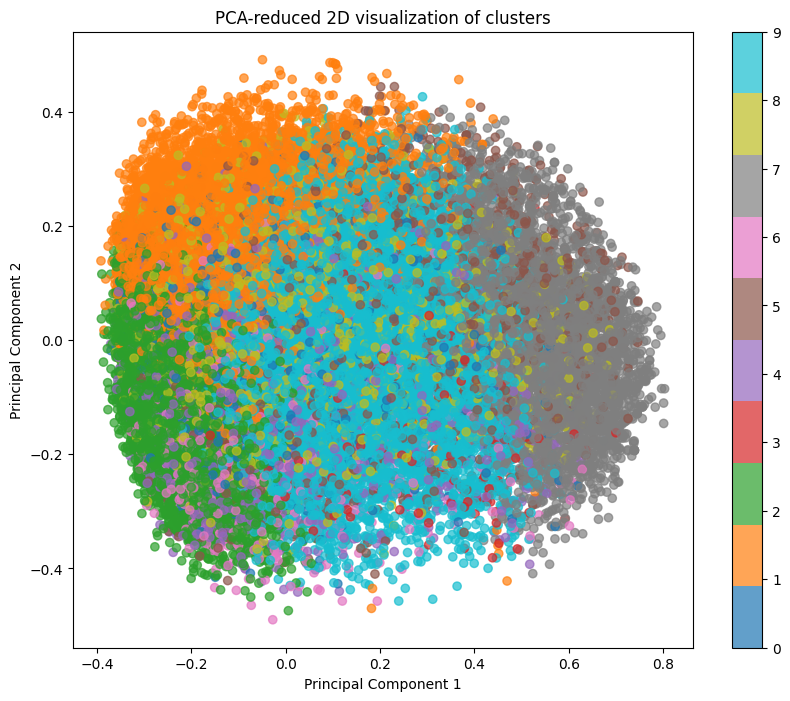

In [32]:
plot_clusters(embeddings, labels, n_clusters=n_clusters)

In [33]:
for cluster in range(n_clusters):
    print(f"\nCluster {cluster}:")
    cluster_texts = [dataset[i]['text'] for i in range(len(dataset[:]['text'])) if labels[i] == cluster]
    for text in cluster_texts[:5]:
        print(f"- {text}")


Cluster 0:
- Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait üòù
- Lord help me I want to be a mod again. So many damn trolls here
- Oh holy heck :/
- And then they say, ‚ÄúHAHAHAHHA IT WAS RIGHT THERE WOW!‚Äù
- omg [NAME] and his dad walking out together is so cute üòç

Cluster 1:
- My favourite food is anything I didn't have to cook myself.
- Aww... she'll probably come around eventually, I'm sure she was just jealous of [NAME]... I mean, what woman wouldn't be! lol 
- I never thought it was at the same moment, but sometimes after [NAME] sacrifice... sounds logical
- Troll, bro. They know they're saying stupid shit. The motherfucker does nothing but stink up libertarian subs talking shit
- Pretty sure I‚Äôve seen this. He swings away with the harness he is wearing. Still looks painful but I think he lives

Cluster 2:
- Now if he does off himself, everyone will think hes having a laugh screwing with people instead 

## 5. Report

Make a conclusion and write a short report. What are the differnes between the methods used? What are their limitations? What is the applicability of each?

–Ø –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–ª –º–æ–¥–µ–ª—å RuBERTtiny (https://huggingface.co/cointegrated/rubert-tiny) –¥–ª—è —Ä–∞—Å—á–µ—Ç–∞ –≤–µ–∫—Ç–æ—Ä–Ω—ã—Ö –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∏–π –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π. –≠—Ç–∞ –º–æ–¥–µ–ª—å –∏–º–µ–µ—Ç —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å —ç–º–±–µ–¥–¥–∏–Ω–≥–æ–≤ = 312.

–†–∞—Å—á–µ—Ç—ã —É –º–µ–Ω—è –±—ã–ª–∏ –æ—á–µ–Ω—å –¥–æ–ª–≥–∏–º–∏, —Ç–∞–∫ –∫–∞–∫ —è –Ω–µ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–ª –≤—ã—á–∏—Å–ª–µ–Ω–∏—è –Ω–∞ GPU –∏, –≤–æ–æ–±—â–µ –≥–æ–≤–æ—Ä—è, –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–ª –Ω–µ—ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω—ã–µ –Ω–µ–≤–µ–∫—Ç–æ—Ä–∏–∑–æ–≤–∞–Ω–Ω—ã–µ –≤—ã—á–∏—Å–ª–µ–Ω–∏—è.

–ë—ã—Å—Ç—Ä–µ–µ –≤—Å–µ–≥–æ –ø–æ—Å—á–∏—Ç–∞–ª–∞—Å—å –∫–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏—è –Ω–∞ –æ—Å–Ω–æ–≤–µ –µ–≤–∫–ª–∏–¥–æ–≤–∞ –∏ –∫–æ—Å–∏–Ω—É—Å–Ω–æ–≥–æ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏—è. –ü–æ –∫–∞—á–µ—Å—Ç–≤—É –∫–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏–∏ (–µ—Å–ª–∏ —Å—É–¥–∏—Ç—å –ø–æ –∫–∞—Ä—Ç–∏–Ω–∫–µ –ø–æ—Å–ª–µ PCA –Ω–∞ 2 —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç–∏ - —á—Ç–æ, –≤–æ–æ–±—â–µ –≥–æ–≤–æ—Ä—è, –º–æ–∂–µ—Ç –∏ –Ω–µ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª—è—Ç—å –ø–æ–ª–Ω—É—é –∫–∞—Ä—Ç–∏–Ω—É) –æ–Ω–∏ —Å–æ–≤—Å–µ–º –∏–¥–µ–Ω—Ç–∏—á–Ω—ã –ø–æ —Ñ–æ—Ä–º–µ - —Ç–æ –µ—Å—Ç—å –∫–ª–∞—Å—Å—ã –æ—Ç–¥–µ–ª–∏–ª–∏—Å—å –¥—Ä—É–≥ –æ—Ç –¥—Ä—É–≥–∞ –æ—Å—Ç–∞—Ç–æ—á–Ω–æ –Ω–µ–ø–ª–æ—Ö–æ. –û–¥–Ω–∞–∫–æ, —Å—É–¥—è –ø–æ –ø—Ä–∏–º–µ—Ä–∞–º –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –∏–∑ –æ–¥–Ω–∏—Ö –∫–ª–∞—Å—Ç–µ—Ä–æ–≤, –Ω–∞ –º–æ–π –≤–∑–≥–ª—è–¥, —Å—Ö–æ–∂–µ—Å—Ç—å –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –º–µ—Ç–æ–¥–µ –∫–æ—Å–∏–Ω—É—Å–Ω–æ–≥–æ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏—è –ª—É—á—à–µ.

–ö–∞—á–µ—Å—Ç–≤–æ –ø—Ä–∏ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–∏ –¥–∏—Å—Ç–∞–Ω—Ü–∏–∏ –ú–∞—Ö–∞–ª–∞–Ω–æ–±–∏—Å–æ–≤–∞ —Å–æ–≤—Å–µ–º —Å—Ç—Ä–∞–Ω–Ω–æ–µ. –°—É–¥—è –ø–æ –∫–∞—Ä—Ç–∏–Ω–∫–µ –ø–æ—Å–ª–µ PCA –∫–ª–∞—Å—Ç–µ—Ä—ã –ø–æ–ª—É—á–∏–ª–∏—Å—å –ø–ª–æ—Ö–∏–º–∏, –∞ –ø–æ –∞–Ω–∞–ª–∏–∑—É –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –∏–∑ –æ–¥–Ω–æ–≥–æ –∫–ª–∞—Å—Ç–µ—Ä–∞ - –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è –¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ –ø–æ—Ö–æ–∂–∏.

–ü—Ä–∏ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–∏ –º–µ—Ç—Ä–∏–∫–∏ –ø–æ—Ö–æ–∂–µ—Å—Ç–∏ –Ω–∞ –æ—Å–Ω–æ–≤–µ –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–∏ —Ä–∞—Å—á–µ—Ç—ã –±—ã–ª–∏ —Å–∞–º—ã–º–∏ –¥–æ–ª–≥–∏–º–∏ - –Ω–æ –∏ —Ä–µ–∑—É–ª—å—Ç–∞—Ç - –¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ —Ö–æ—Ä–æ—à–∏–π, –∫–∞–∫ –∫–∞—Ä—Ç–∏–Ω–∫–∞ –ø–æ—Å–ª–µ PCA –Ω–µ–ø–ª–æ—Ö–∞—è, —Ç–∞–∫ –∏ –ø—Ä–∏–º–µ—Ä—ã –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –∏–∑ –æ–¥–Ω–æ–≥–æ –∫–ª–∞—Å—Ç–µ—Ä–∞.

### –†–∞–∑–Ω–∏—Ü–∞ –º–µ–∂–¥—É –∏—Å–ø–æ–ª—å–∑—É–µ–º—ã–º–∏ –º–µ—Ç–æ–¥–∞–º–∏

1. –ï–≤–∫–ª–∏–¥–æ–≤–æ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–µ - —Å–∞–º—ã–π –±—ã—Å—Ç—Ä—ã–π –º–µ—Ç–æ–¥, —Ç.–∫. —Ç—Ä–µ–±—É–µ—Ç –Ω–∞–∏–º–µ–Ω—å—à–µ–µ —á–∏—Å–ª–æ –≤—ã—á–∏—Å–ª–µ–Ω–∏–π. –ù–∞–¥–æ —é–∑–∞—Ç—å –∫–æ–≥–¥–∞ –∑–Ω–∞—á–µ–Ω–∏–π –≤–µ–∫—Ç–æ—Ä–æ–≤ –∏–º–µ—é—Ç —Å—Ö–æ–∂–∏–µ –º–∞—Å—à—Ç–∞–±—ã, –∏–Ω–∞—á–µ –±—É–¥–µ—Ç –ø–æ–ª—É—á–∞—Ç—å "–Ω–µ—Ö–æ—Ä–æ—à–∏–µ" —Ä–µ–∑—É–ª—å–∞—Ç—ã. –¢–∞–∫–∂–µ —Å—Ç–æ–∏—Ç –æ—Ç–º–µ—Ç–∏—Ç—å, —á—Ç–æ –ø—Ä–æ—Å—Ç–æ–µ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–µ –Ω–µ –≤—Å–µ–≥–¥–∞ –±—É–¥–µ—Ç –æ—Ç—Ä–∞–∂–∞—Ç—å —Å–µ–º–∞–Ω—Ç–∏—á–µ—Å–∫–∏–µ —Ä–∞–∑–ª–∏—á–∏—è –º–µ–∂–¥—É –≤–µ—Ç–∫–æ—Ä–∞–º–∏-–ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è–º–∏. –¢–∞–∫–∂–µ –Ω–µ —Å—Ç–æ–∏—Ç –∑–∞–±—ã–≤–∞—Ç—å –ø—Ä–æ dimentionality curse –ø—Ä–∏ —Ä–∞—Å—á–µ—Ç–µ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏—è
2. –ö–æ—Å–∏–Ω—É—Å–Ω–æ–µ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–µ - —Ç–æ–∂–µ –±—ã—Å—Ç—Ä—ã–π –∏ —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω—ã–π –º–µ—Ç–æ–¥, –Ω–∞–∏–±–æ–ª–µ–µ –ø–æ–¥—Ö–æ–¥–∏—Ç –¥–ª—è —Ç–µ–∫—Å—Ç–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö, —Ç.–∫. —Ç—É—Ç –∏–º–µ–Ω–Ω–æ –Ω–∞–º –∏ –≤–∞–∂–Ω–∞ –Ω–∞–ø—Ä–∞–≤–ª–µ–Ω–Ω–æ—Å—Ç—å –≤–µ–∫—Ç–æ—Ä–æ–≤-–ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π, —á—Ç–æ–±—ã —Å—Ä–∞–≤–Ω–∏—Ç—å –∏—Ö —Å–µ–º–∞–Ω—Ç–∏–∫—É.
3. –ú–∞—Ö–∞–ª–∞–Ω–æ–±–∏—Å–æ–≤–∞ –¥–∏—Å—Ç–∞–Ω—Ü–∏—è - —Ç—è–∂–µ–ª—ã–π –≤ –ø–ª–∞–Ω–µ –≤—ã—á–∏—Å–ª–µ–Ω–∏–π –º–µ—Ç–æ–¥ - —Ç—Ä–µ–±—É–µ—Ç—Å—è –≤—ã—á–∏—Å–ª–µ–Ω–∏—è –æ–±—Ä–∞—Ç–Ω–æ–π –º–∞—Ç—Ä–∏—Ü—ã - —á—Ç–æ —Ç–æ–∂–µ –Ω–µ –æ—á–µ–Ω—å —Ö–æ—Ä–æ—à–æ. –û–¥–Ω–∞–∫–æ, –∏–∑-–∑–∞ —Ç–æ–≥–æ —á—Ç–æ –æ–Ω —É—á–∏—Ç—ã–≤–∞–µ—Ç –∫–æ–≤–∞—Ä–∏–∞—Ü–∏—é –º–µ–∂–¥—É –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–º–∏ - —ç—Ç–æ –ø–æ–∑–≤–æ–ª—è–µ—Ç —Ç–æ—á–Ω–æ –∏–∑–º–µ—Ä—è—Ç—å —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–µ –≤ –º–Ω–æ–≥–æ–º–µ—Ä–Ω–æ–º (–∫–∞–∫–æ–µ —É –Ω–∞—Å –∏ –µ—Å—Ç—å –ø—Ä–∏ —ç–º–±–µ–¥–¥–∏–Ω–≥–∞—Ö –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π) –ø—Ä–æ—Å—Ç—Ä–∞–Ω—Å—Ç–≤–µ.
4. –ö–æ—Ä—Ä–µ–ª—è—Ü–∏–æ–Ω–Ω–æ–µ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–µ - –º–æ–∂–Ω–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –¥–ª—è –∞–Ω–∞–ª–∏–∑–∞ —Å—Ö–æ–∂–µ—Å—Ç–∏ —Ç–µ–∫—Å—Ç–æ–≤, –∫–æ–≥–¥–∞ –≤–∞–∂–Ω–∞ —Å—Ç–µ–ø–µ–Ω—å –ª–∏–Ω–µ–π–Ω–æ–π –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –º–µ–∂–¥—É –≤–µ–∫—Ç–æ—Ä–Ω—ã–º–∏ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∏—è–º–∏. –û–¥–Ω–∞–∫–æ —Ç—É—Ç –º—ã –∏–≥–Ω–æ—Ä–∏—Ä—É–µ–º —Å—Ö–æ–∂–µ—Å—Ç–∏, –∫–æ—Ç–æ—Ä—ã–µ –º–æ–≥—É—Ç –∏–º–µ—Ç—å –Ω–µ–ª–∏–Ω–µ–π–Ω—ã–π —Ö–∞—Ä–∞–∫—Ç–µ—Ä, –∞ —Ç–∞–∫–∂–µ –∏–≥–Ω–æ—Ä–∏—Ä—É–µ–º –∞–±—Å–æ–ª—é—Ç–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –≤–µ–∫—Ç–æ—Ä–æ–≤.

–í –∏—Ç–æ–≥–µ, –º–æ–∂–Ω–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –ª—é–±—É—é –º–µ—Ç—Ä–∏–∫—É, —Ç–∫ –∫–∞–∂–¥–∞—è –∏–º–µ–µ—Ç —Å–≤–æ–∏ + –∏ -. –û–¥–Ω–∞–∫–æ –∫–∞–∫ –º–Ω–µ –∫–∞–∂–µ—Ç—Å—è –Ω–∞–∏–±–æ–ª–µ–µ –ø–æ–¥—Ö–æ–¥–∏—Ç –∫–æ—Å–∏–Ω—É—Å–Ω–æ–µ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–µ, –∏–∑-–∑–∞ –∫–æ–º–±–∏–Ω–∞—Ü–∏–∏ –≤—Ä–µ–º–µ–Ω–∏ –≤—ã—á–∏—Å–ª–µ–Ω–∏–π –∏ –ø—Ä–∏–µ–º–ª–∏–º–æ–≥–æ –∫–∞—á–µ—Å—Ç–≤–∞.